In [2]:
import numpy as np
import pandas as pd

In [ ]:
mjd = pd.read_csv('GRCAT07001ACC.sec', delimiter = r'\s+', names = ['mjd'], skiprows = 8, nrows=1)
data = pd.read_csv('GRCAT07001ACC.sec', delimiter = r'\s+', names = ['dmjd','R_lin','S_lin','W_lin','R_ang','S_ang','W_ang'], skiprows = 9)
display(mjd)
display(data)
data.plot(x='dmjd')


,dmjd,R_lin,S_lin,W_lin,R_ang,S_ang,W_ang
0,0.000000,0.000011,0.000048,-0.000003,0.301015,-0.329681,-0.039378
1,0.000012,0.000011,0.000048,-0.000003,0.301055,-0.329769,-0.039365
2,0.000023,0.000011,0.000048,-0.000003,0.301034,-0.329567,-0.039391
3,0.000035,0.000011,0.000048,-0.000003,0.301044,-0.329789,-0.039386
4,0.000046,0.000011,0.000048,-0.000003,0.301064,-0.329831,-0.039393
...,...,...,...,...,...,...,...
86394,0.999931,0.000011,0.000007,-0.000012,0.301017,-0.329934,-0.039382
86395,0.999942,0.000011,0.000007,-0.000012,0.300989,-0.329819,-0.039438
86396,0.999954,0.000011,0.000007,-0.000012,0.300978,-0.329556,-0.039427
86397,0.999965,0.000011,0.000007,-0.000012,0.300958,-0.329908,-0.039864


,mjd
0,54101.0


<Axes: xlabel='dmjd'>

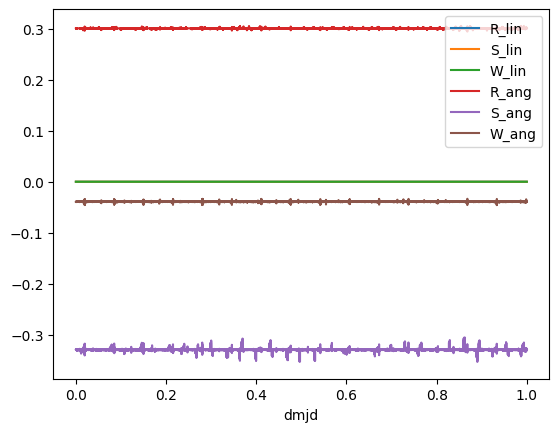